In [1]:
import os
import json
import hoomd
import codecs

import numpy as np

import polychrom_hoomd.log as log
import polychrom_hoomd.build as build
import polychrom_hoomd.forces as forces
import polychrom_hoomd.render as render

from polykit.generators.initial_conformations import grow_cubic

In [2]:
# Initialise HooMD on the CPU or GPU, based on availability
hoomd_device = build.get_hoomd_device()

HOOMD is running on the following GPU(s):
[0] NVIDIA A100-PCIE-40GB 108 SM_8.0 @ 1.41 GHz, 40354 MiB DRAM


In [3]:
# Generate RNG seed
rng_seed = os.urandom(2)
rng_seed = int(codecs.encode(rng_seed, 'hex'), 16)

print("Using entropy-harvested random seed: %d" % rng_seed)

Using entropy-harvested random seed: 34452


In [4]:
# Initialize empty simulation object
system = hoomd.Simulation(device=hoomd_device, seed=rng_seed)

In [5]:
# Simulate two chromosomes comprised of 5000 (resp. 10000) monomers each, with number density 0.2
density = 0.2
chromosome_sizes = [5000, 10000]

In [6]:
# Confine chromosomes within a sphere of appropriate radius
number_of_monomers = sum(chromosome_sizes)
confinement_radius = (3*number_of_monomers / (4*np.pi*density))**(1/3.)

In [7]:
# Set simulation box large enough to accomodate the chromosomes
snapshot = build.get_simulation_box(box_length=2*confinement_radius, pad=1.)

In [8]:
# Build random, dense initial conformations
inscribed_cube_length = confinement_radius*2/3**.5
monomer_positions = grow_cubic(N=number_of_monomers, boxSize=int(inscribed_cube_length))

In [9]:
# Populate snapshot with the generated chains
build.set_chains(snapshot, monomer_positions, chromosome_sizes)

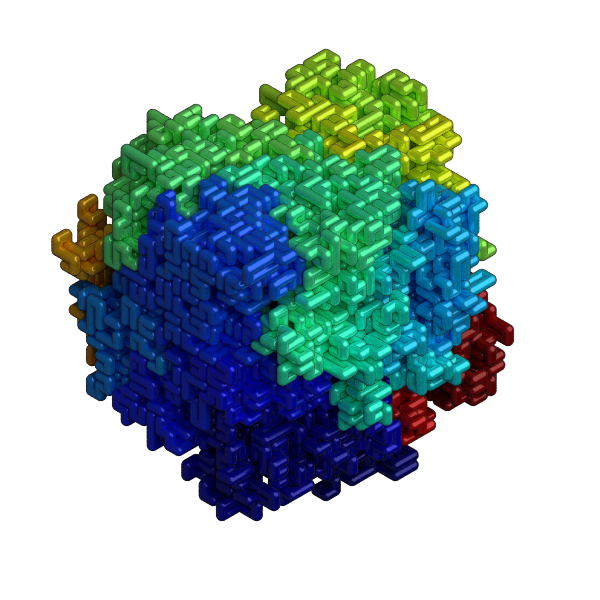

In [10]:
# Visualize starting conformation using the Fresnel backend
render.fresnel(snapshot, cmap="jet").static(pathtrace=True)

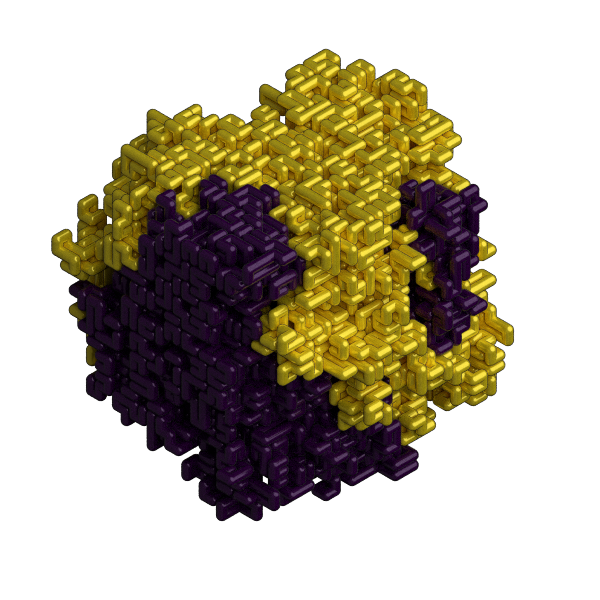

In [11]:
# Render individual chromosomes
render.fresnel(snapshot, show_chromosomes=True).static(pathtrace=True)

In [12]:
# Setup HooMD simulation object
system.create_state_from_snapshot(snapshot)

In [13]:
# Setup neighbor list
nl = hoomd.md.nlist.Cell(buffer=0.4)

In [14]:
# Read input force parameters
with open("force_dict_homopolymer.json", 'r') as dict_file:
    force_dict = json.load(dict_file)

print(json.dumps(force_dict, indent=4, sort_keys=True))

{
    "Angular forces": {
        "Curvature": {
            "Stiffness": 1.5,
            "Type": "KG"
        }
    },
    "Bonded forces": {
        "Backbone": {
            "Rest length": 1.0,
            "Type": "Harmonic",
            "Wiggle distance": 0.1
        }
    },
    "External forces": {
        "Confinement": {}
    },
    "Non-bonded forces": {
        "Repulsion": {
            "Cutoff": 1.0,
            "Matrix": {
                "A": {
                    "A": 5.0,
                    "B": 5.0
                },
                "B": {
                    "A": 5.0,
                    "B": 5.0
                }
            },
            "Type": "Polychrom"
        }
    }
}


In [15]:
# Set chromosome excluded volume
repulsion_forces = forces.get_repulsion_forces(nl, **force_dict)

In [16]:
# Set bonded/angular potentials
bonded_forces = forces.get_bonded_forces(**force_dict)
angular_forces = forces.get_angular_forces(**force_dict)

In [17]:
# Set spherical confining wall
force_dict['External forces']['Confinement']['Spherical'] = dict(R=confinement_radius)
confinement_forces = forces.get_confinement_forces(**force_dict)

In [18]:
# Define full force_field
force_field = repulsion_forces + bonded_forces + angular_forces + confinement_forces

In [19]:
# HooMD to openMM time conversion factor
t_conv = (1.67377*10**-27/(1.380649*10**-23*300))**0.5

In [20]:
# Initialize integrators and Langevin thermostat
langevin = hoomd.md.methods.Langevin(filter=hoomd.filter.All(), kT=1.0)
integrator = hoomd.md.Integrator(dt=70*t_conv, methods=[langevin], forces=force_field)

In [21]:
# Setup log and simulation engines
logger = log.get_logger(system)

system.operations.integrator = integrator
system.operations.writers.append(log.table_formatter(logger, period=10000))

In [22]:
# Run
system.run(1e5)

Simulation.timestep  Simulation.tps     Status.etr    Thermo.kinetic_temperature
       10000           4717.68886     0:00:19.077138           1.01858          
       20000           5434.98200     0:00:14.719460           1.00828          
       30000           5728.99061     0:00:12.218557           1.01580          
       40000           5887.37638     0:00:10.191297           1.01814          
       50000           5992.83698     0:00:08.343294           1.02361          
       60000           6055.58229     0:00:06.605475           1.01784          
       70000           6107.83484     0:00:04.911724           1.02095          
       80000           6143.44965     0:00:03.255500           1.01936          
       90000           6176.68494     0:00:01.618991           1.01588          
      100000           6201.60529        0:00:00               1.02440          


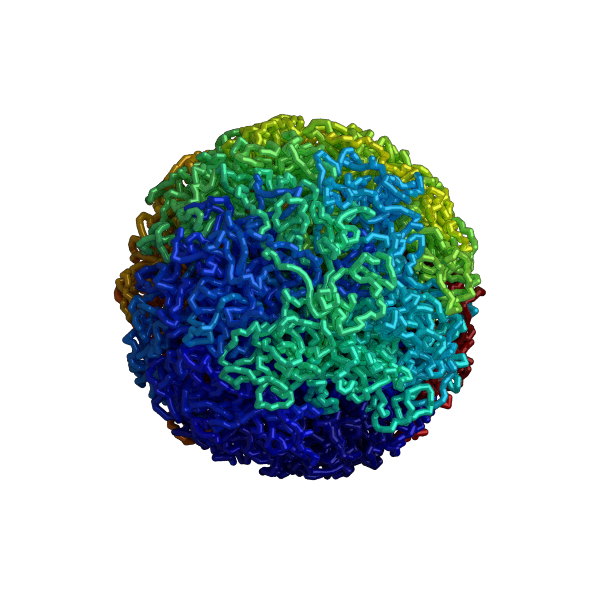

In [23]:
# Visualize new conformation
snapshot_relaxed = system.state.get_snapshot()
render.fresnel(snapshot_relaxed, cmap="jet").static(pathtrace=True)

In [24]:
# Setup domains by assigning monomers to a type 0 (A) or 1 (B)
domain_size = 500

motif = np.zeros(3*domain_size)
motif[domain_size:2*domain_size] = 1

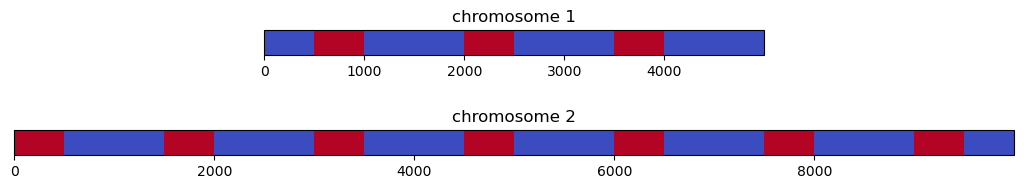

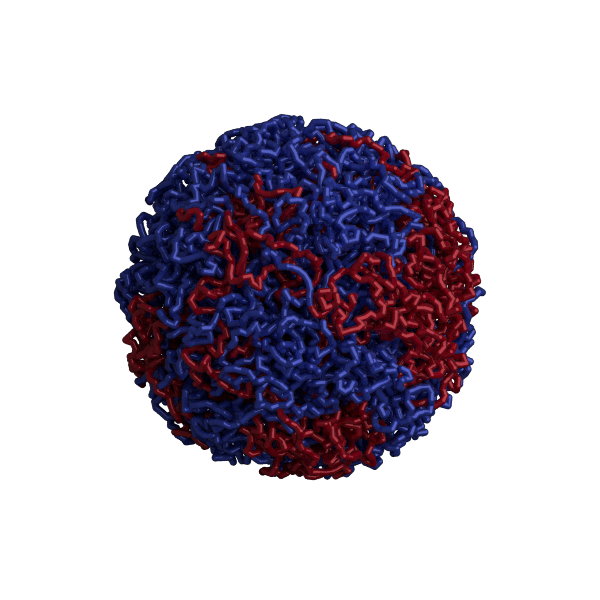

In [25]:
# Assign and visualize domains in 1D/3D
snapshot_relaxed.particles.typeid[:] = np.tile(motif, number_of_monomers//motif.shape[0])

render.domain_viewer(snapshot_relaxed, cmap="coolwarm")
render.fresnel(snapshot_relaxed, show_compartments=True, cmap="coolwarm").static(pathtrace=True)

In [26]:
# Load updated snapshot
system.state.set_snapshot(snapshot_relaxed)

In [27]:
# Set a pseudo square well attraction force acting on B-type monomers
force_dict["Non-bonded forces"]["Attraction"] = {
    "Cutoff": 1.5,
    "Matrix": {
        "A": {
            "A": 0,
            "B": 0
        },
        "B": {
            "A": 0,
            "B": 0.2
        }
    },
    "Type": "Polychrom"
}

In [28]:
# Update force field, including a DPD thermostat
dpd_forces = forces.get_dpd_forces(nl, **force_dict)
attraction_forces = forces.get_attraction_forces(nl, **force_dict)

force_field += attraction_forces + dpd_forces

Setting up DPD with the conservative force contribution disabled


In [29]:
# Setup new DPD integrator
system.operations.remove(integrator)
system.operations.remove(system.operations.writers[0])

nve = hoomd.md.methods.NVE(filter=hoomd.filter.All())
dpd_integrator = hoomd.md.Integrator(dt=5e-3, methods=[nve], forces=force_field)

/home1/tortora/.conda/envs/polychrom-hoomd/lib/python3.10/site-packages/hoomd/md/methods/methods.py:699: FutureWarning: NVE is deprecated and wil be removed in hoomd 4.0. In version 4.0, use the ConstantVolume method without a thermostat.
  warnings.warn(


In [30]:
# Update simulation engine
system.operations.integrator = dpd_integrator
system.operations.writers.append(log.table_formatter(logger, period=10000))

In [31]:
# Run
system.run(1e5)

Simulation.timestep  Simulation.tps     Status.etr    Thermo.kinetic_temperature
      110000           5131.02616     0:00:17.540351           1.05733          
      120000           6038.59884     0:00:13.248106           1.04521          
      130000           6415.99124     0:00:10.910239           1.03955          
      140000           6622.51656     0:00:09.060000           1.02883          
      150000           6748.12355     0:00:07.409467           1.02149          
      160000           6842.80336     0:00:05.845557           1.03365          
      170000           6909.51798     0:00:04.341837           1.02820          
      180000           6963.28181     0:00:02.872209           1.04269          
      190000           7001.21978     0:00:01.428323           1.03856          
      200000           7030.26630        0:00:00               1.03335          


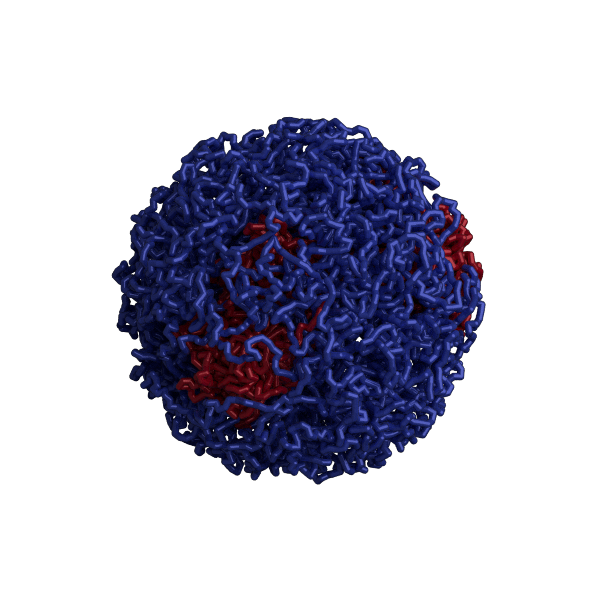

In [32]:
# Visualize new conformation
snapshot_collapsed = system.state.get_snapshot()
render.fresnel(snapshot_collapsed, show_compartments=True, cmap="coolwarm").static(pathtrace=True)